<a href="https://colab.research.google.com/github/wolfram-laube/mlpc-project_team-park/blob/main/task_2/report_wolfram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Consistency & Quality

#### a. Feature Statistics Analysis
- **Method**: Use statistical analysis methods (mean, median, standard deviation, outliers detection via IQR or Z-score) on your feature data to detect inconsistencies.
- **Tip**: Highlight any features with high variance or those that deviate significantly from the rest, indicating potential labeling errors or outliers.

* Load and Inspect Data: Start by loading the metadata and feature files (.npy format) to understand the structure of your dataset. Inspect the basic statistics (mean, median, standard deviation) of the features to get an initial sense of the data.
* Identify Outliers: Look for outliers in the dataset by plotting histograms or using statistical methods (e.g., z-scores, IQR). Outliers might indicate wrongly labeled data or anomalies in the recording process.
* Label Consistency: Check if there are any labels that seem inconsistent with the majority of the data. For example, if you have text labels, ensure they are spelled correctly and used consistently.

### 1. Loading the Data

Given the size of the `.npy` file, it's essential to manage memory usage carefully. `numpy`'s `load` function is quite efficient, but we should ensure the system has enough RAM to handle the data. If memory issues arise, consider processing the data in chunks if possible.


In [1]:
import numpy as np
import pandas as pd

# Assuming the path to your file is correct on your local system
development_data = np.load('../dataset/development.npy')

# Aliases used in the folllowing
X = development_data
features = development_data
data = development_data

# Load the mapping file, which should have columns like 'Feature_ID_Modulo_175' and 'Feature_Name'
feature_name_mapping = pd.read_csv('../dataset/idx_to_feature_name.csv')
# Print the column names to verify
print("Columns in feature_name_mapping:", feature_name_mapping.columns)

# If the printout shows that the index column is named differently or if we assume the file does not have a header
# and 'index' should actually be the first unnamed column, we can adjust by renaming it or setting the index directly:

# Check the first few rows to understand the layout
print(feature_name_mapping.head())

# Assuming the first column is what you mean by 'index' and it's not named, you might need to rename it:
feature_name_mapping.rename(columns={ feature_name_mapping.columns[0]: "index" }, inplace=True)

# Set the renamed 'index' column as the DataFrame index
#feature_name_mapping.set_index('index', inplace=True)
print("Columns in feature_name_mapping:", feature_name_mapping.columns)

Columns in feature_name_mapping: Index(['index', 'feature_name'], dtype='object')
   index feature_name
0      0  bandwidth_0
1      1   centroid_0
2      2   contrast_0
3      3   contrast_1
4      4   contrast_2
Columns in feature_name_mapping: Index(['index', 'feature_name'], dtype='object')



### 2. Inspecting the Data

After loading the data, you'll want to understand its structure:


In [2]:
print(f"Data Shape: {development_data.shape}")

Data Shape: (45296, 175, 44)


### 3. Basic Statistical Analysis

Next, you can perform some basic statistical analyses to understand the data's distribution. Calculating statistics like mean, median, and standard deviation can provide insights into the nature of your features.


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

# Load the dataset from the NPY file
#data = np.load('path_to_your_dataset.npy')

# Swap axes to have the frames dimension last, then flatten the last two dimensions
data_swapped = np.swapaxes(data, 1, 2)  # This changes the shape to (45296, 44, 175)
data_flattened = data_swapped.reshape(data_swapped.shape[0], -1)  # This changes the shape to (45296, 7700)

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_flattened)
X_std = data_flattened

# Compute the mean, standard deviation, and skewness of each of the 7700 flattened features across all samples
feature_means = np.mean(data_flattened, axis=0)
feature_stds = np.std(data_flattened, axis=0)
feature_skewness = skew(data_flattened, axis=0)

# Ensure we have 7700 means, stds, and skewness
assert feature_means.shape[0] == 7700 and feature_stds.shape[0] == 7700 and feature_skewness.shape[0] == 7700, \
       "The calculation did not result in 7700 features. Check data structure."

# Create a DataFrame for better data handling and saving
statistics_df = pd.DataFrame({
    'Mean': feature_means,
    'StdDev': feature_stds,
    'Skewness': feature_skewness
})

# Save the DataFrame to a CSV file
statistics_df.to_csv('feature_statistics.csv', index_label='Feature')

# Assuming the index represents 'Feature_ID', we set the DataFrame's index as 'Feature_ID'
statistics_df.reset_index(inplace=True)
statistics_df.rename(columns={'index': 'Feature_ID'}, inplace=True)

# Add a 'Feature_ID_Modulo_175' column to statistics_df for correct mapping
statistics_df['Feature_ID_Modulo_175'] = statistics_df['Feature_ID'] % 175

# Ensure that the mapping DataFrame has 'index' set as the index
# Print the column names to verify
print("Columns in feature_name_mapping:", feature_name_mapping.columns)
feature_name_mapping.set_index('index', inplace=True)

# Map the 'feature_name' to each entry in statistics_df based on 'Feature_ID_Modulo_175'
statistics_df['feature_name'] = statistics_df['Feature_ID_Modulo_175'].map(feature_name_mapping['feature_name'])

# Now that 'feature_name' is incorporated, sort by 'StdDev'
sorted_statistics_stddev_df = statistics_df.sort_values(by='StdDev', ascending=False)
sorted_statistics_skewness_df = statistics_df.sort_values(by='Skewness', ascending=False)

# Display the top 10 features with the highest standard deviation
print(sorted_statistics_stddev_df[['Feature_ID', 'Mean', 'StdDev', 'Skewness', 'feature_name']].head(10))

# Display the top 10 features with the highest skewness
print(sorted_statistics_skewness_df[['Feature_ID', 'Mean', 'StdDev', 'Skewness', 'feature_name']].head(10))

# Yummi, directly generate the LaTeX tables:
# If there's an unwanted 'index' column, you can drop it
print(sorted_statistics_stddev_df.columns)
if 'Feature_ID_Modulo_175' in sorted_statistics_stddev_df.columns:
    sorted_statistics_stddev_df.drop(columns=['Feature_ID_Modulo_175'], inplace=True)
latex_table = sorted_statistics_stddev_df.head(10).to_latex(index=False, escape=False, 
                                                     column_format='ccccc',
                                                     header=['Feature ID', 'Feature Name', 'Mean', 'StdDev', 'Skewness'],
                                                     float_format="{:0.2f}".format)

# Print the generated LaTeX table string
print(latex_table)

# If there's an unwanted 'index' column, you can drop it
if 'Feature_ID_Modulo_175' in sorted_statistics_skewness_df.columns:
    sorted_statistics_skewness_df.drop(columns=['Feature_ID_Modulo_175'], inplace=True)
latex_table = sorted_statistics_skewness_df.head(10).to_latex(index=False, escape=False, 
                                                     column_format='ccccc',
                                                     header=['Feature ID', 'Feature Name', 'Mean', 'StdDev', 'Skewness'],
                                                     float_format="{:0.2f}".format)

# Print the generated LaTeX table string
print(latex_table)

# Function to format a row for LaTeX
def format_row(row):
    return f"{int(row['Feature_ID'])} & {row['feature_name']} & {row['Mean']:.2f} & {row['StdDev']:.2f} & {row['Skewness']:.2f}"

# Generate rows for each part
stddev_rows = sorted_statistics_stddev_df.head(10).apply(format_row, axis=1).tolist()
skewness_rows = sorted_statistics_skewness_df.head(10).apply(format_row, axis=1).tolist()

# Combine rows into one table
latex_rows = "\n".join(f"    {s} & {k} \\\\" for s, k in zip(stddev_rows, skewness_rows))

# Final LaTeX table string
latex_table = f"""
\\begin{{table}}[ht]
  \\caption{{Feature Analysis by Standard Deviation and Skewness}}
  \\label{{tab:feature_analysis}}
  \\centering
  \\begin{{tabular}}{{ccccc|ccccc}}
    \\toprule
    \\multicolumn{{5}}{{c|}}{{Sorted by StdDev}} & \\multicolumn{{5}}{{c}}{{Sorted by Skewness}} \\\\
    \\cmidrule(r){{1-5}} \\cmidrule(r){{6-10}}
    Feature ID & Feature Name & Mean & StdDev & Skewness & Feature ID & Feature Name & Mean & StdDev & Skewness \\\\
    \\midrule
    {latex_rows}
    \\bottomrule
  \\end{{tabular}}
\\end{{table}}
"""

print(latex_table)


Columns in feature_name_mapping: Index(['index', 'feature_name'], dtype='object')
      Feature_ID         Mean       StdDev  Skewness feature_name
7348        7348  1782.251316  2974.490869  1.477414        yin_0
7523        7523  1687.881092  2930.306935  1.565242        yin_0
173          173  1979.879345  2929.104382  1.333895        yin_0
7173        7173  1702.177766  2912.103519  1.557433        yin_0
348          348  1981.510955  2896.404428  1.337120        yin_0
7698        7698  1566.759853  2857.505295  1.693624        yin_0
523          523  1981.604589  2853.773442  1.341666        yin_0
6998        6998  1629.710881  2850.655633  1.635053        yin_0
698          698  1987.756082  2810.547554  1.341844        yin_0
6823        6823  1552.071581  2779.508377  1.720686        yin_0
      Feature_ID       Mean      StdDev   Skewness feature_name
6997        6997  13.382564  148.420954  72.708914      power_0
6822        6822  15.281200  154.514164  68.476523      power_0



### 4. Identifying Outliers

#### **Statistical Methods**

##### Z-Score
The Z-score represents how many standard deviations away a data point is from the mean. Data points with a Z-score beyond a certain threshold (commonly 3 or -3) are considered outliers.


In [3]:
from scipy.stats import zscore

# Assuming 'features' is a NumPy array with your data
z_scores = np.abs(zscore(data_flattened, axis=0))
z_outliers = np.where(z_scores > 3)


##### Interquartile Range (IQR)
The IQR is the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Data points that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR are considered outliers.


In [4]:
Q1 = np.percentile(data_flattened, 25, axis=0)
Q3 = np.percentile(data_flattened, 75, axis=0)
IQR = Q3 - Q1

# Identifying outliers
outlier_condition = ((data_flattened < (Q1 - 1.5 * IQR)) | (data_flattened > (Q3 + 1.5 * IQR)))
iqr_outliers = np.where(outlier_condition)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


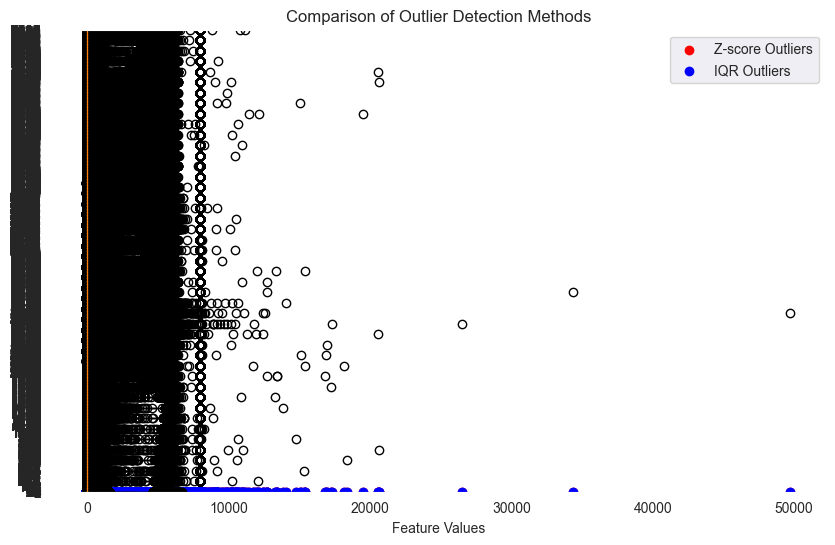

In [8]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 6))
plt.boxplot(data_flattened, vert=False)

# Highlight outliers identified by Z-score
plt.scatter(data_flattened[z_outliers], np.ones_like(data_flattened[z_outliers]), color='red', label='Z-score Outliers')
# Highlight outliers identified by IQR
plt.scatter(data_flattened[iqr_outliers], np.ones_like(data_flattened[iqr_outliers]) * 1.05, color='blue', label='IQR Outliers')

plt.legend()
plt.title('Comparison of Outlier Detection Methods')
plt.xlabel('Feature Values')

#plt.savefig('fig/outliers.eps')
plt.show()

In [6]:
import numpy as np
from scipy.stats import skew, zscore
import pandas as pd

# Load the dataset from the NPY file
#data = np.load('path_to_your_dataset.npy')

# Swap axes to have the frames dimension last, then flatten the last two dimensions
data_swapped = np.swapaxes(data, 1, 2)  # Changes shape to (45296, 44, 175)
data_flattened = data_swapped.reshape(data_swapped.shape[0], -1)  # Changes shape to (45296, 7700)

# Compute the mean, standard deviation, skewness, and z-score variance
feature_means = np.mean(data_flattened, axis=0)
feature_stds = np.std(data_flattened, axis=0)
feature_skewness = skew(data_flattened, axis=0)
feature_zscores = zscore(data_flattened, axis=0)
feature_zscore_variance = np.var(feature_zscores, axis=0)

# Generate feature labels and modulo values
feature_labels = [f'Feature_{i} (Modulo_175: {i % 175})' for i in range(7700)]
modulo_values = [i % 175 for i in range(7700)]

# Create a DataFrame
statistics_df = pd.DataFrame({
    'Feature': feature_labels,
    'Modulo_175': modulo_values,
    'Mean': feature_means,
    'StdDev': feature_stds,
    'Skewness': feature_skewness,
    'ZscoreVariance': feature_zscore_variance
})

# Sort the DataFrame by Modulo_175, then by Feature
statistics_df.sort_values(by=['Modulo_175', 'Feature'], inplace=True)

# Save the sorted DataFrame to a CSV file
statistics_df.to_csv('feature_statistics_grouped_by_modulo_with_zscores.csv', index=False)

# Print out the first 10 statistics to verify the grouping and ordering
print("First 10 feature statistics grouped by Modulo 175 with z-score variance:")
print(statistics_df.head(10))


First 10 feature statistics grouped by Modulo 175 with z-score variance:
                           Feature  Modulo_175         Mean      StdDev   
0        Feature_0 (Modulo_175: 0)           0  3039.426928  666.770221  \
1050  Feature_1050 (Modulo_175: 0)           0  2970.639579  699.928799   
1225  Feature_1225 (Modulo_175: 0)           0  2938.324339  718.930714   
1400  Feature_1400 (Modulo_175: 0)           0  2900.405589  745.131470   
1575  Feature_1575 (Modulo_175: 0)           0  2832.013831  780.892008   
175    Feature_175 (Modulo_175: 0)           0  3038.201326  662.446877   
1750  Feature_1750 (Modulo_175: 0)           0  2725.283312  828.939913   
1925  Feature_1925 (Modulo_175: 0)           0  2579.910661  866.525494   
2100  Feature_2100 (Modulo_175: 0)           0  2364.042270  875.014814   
2275  Feature_2275 (Modulo_175: 0)           0  2048.849113  791.511669   

      Skewness  ZscoreVariance  
0    -1.444696             1.0  
1050 -1.010054             1.0  
12


#### **Visualization**

##### Box Plots
Box plots visually show the distribution of the data, including outliers. Points that fall outside of the whiskers (1.5 times the IQR) are typically considered outliers.


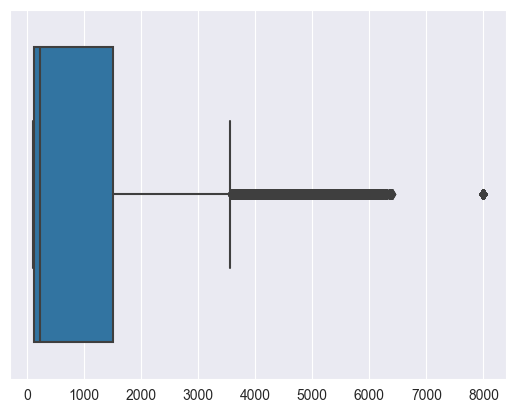

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example for one feature
sns.boxplot(x=features[:,173,9])
plt.savefig('fig/boxplot_skew.eps')
plt.show()

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your dataset
#data = np.load('path_to_your_dataset.npy')

# Flatten the data as before, if not already flattened
#data_flattened = data.reshape(data.shape[0], -1)

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_flattened)

# Apply PCA
pca = PCA(n_components=10)  # Adjust n_components as needed
principal_components = pca.fit_transform(data_standardized)

# Now, principal_components contains the transformed data
# You can explore the variance explained by each component
print(f"Variance explained by the principal components: {pca.explained_variance_ratio_}")

# Additional code could be used to plot these components, analyze them, or use them in further analyses


Variance explained by the principal components: [0.12958126 0.04916548 0.04111032 0.02228137 0.01746072 0.01485417
 0.01260755 0.0114683  0.01040324 0.00934161]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


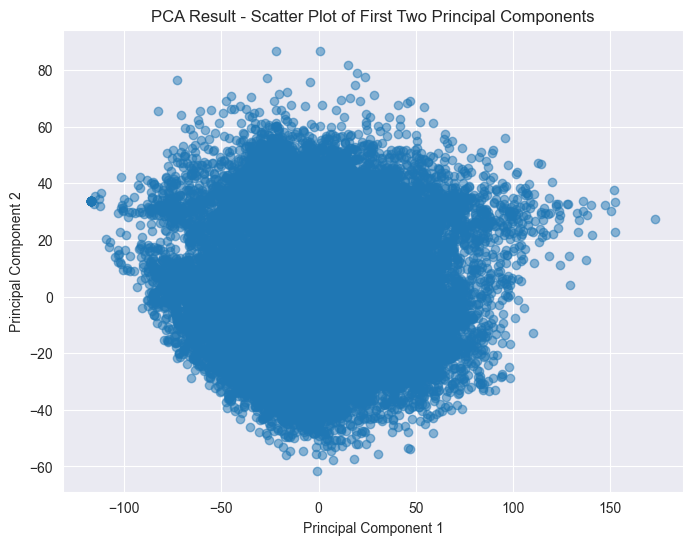

In [10]:
import matplotlib.pyplot as plt

# Assuming principal_components is the result from PCA with at least two components
# Each row in principal_components corresponds to a sample, and columns correspond to the components

# Extract the first two components for plotting
x = principal_components[:, 0]
y = principal_components[:, 1]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.title('PCA Result - Scatter Plot of First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

plt.savefig('fig/scatterplot_first_2_pca.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


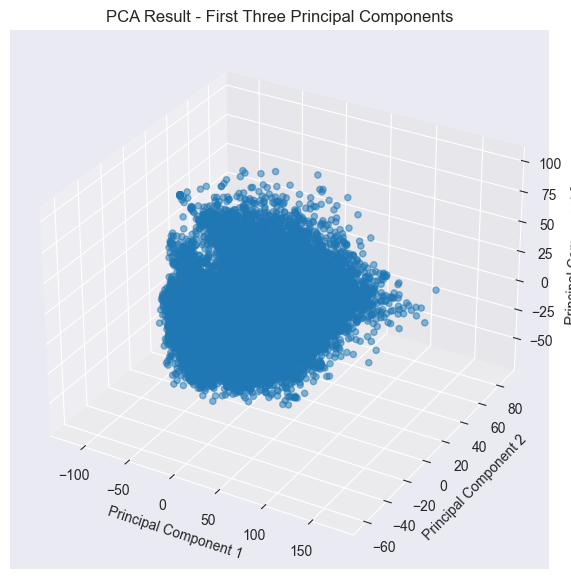

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming principal_components has 10 components and each row is a sample
x = principal_components[:, 0]  # First component
y = principal_components[:, 1]  # Second component
z = principal_components[:, 2]  # Third component

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, alpha=0.5)
ax.set_title('PCA Result - First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.savefig('fig/scatterplot_first_3_pca.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


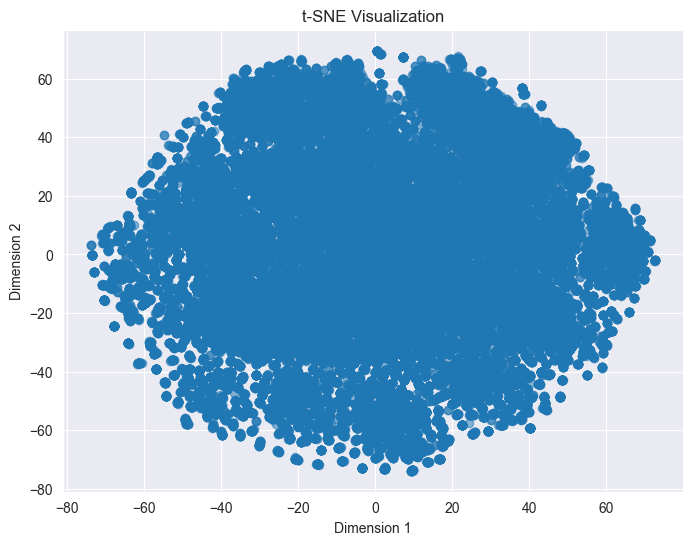

In [12]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Load your dataset
#data = np.load('path_to_your_dataset.npy')

# Flatten and standardize the data
#data_flattened = data.reshape(data.shape[0], -1)
#scaler = StandardScaler()
#data_standardized = scaler.fit_transform(data_flattened)

# Optionally, apply PCA here for initial dimensionality reduction

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(data_standardized)

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.savefig('fig/scatterplot_first_2_tsne.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


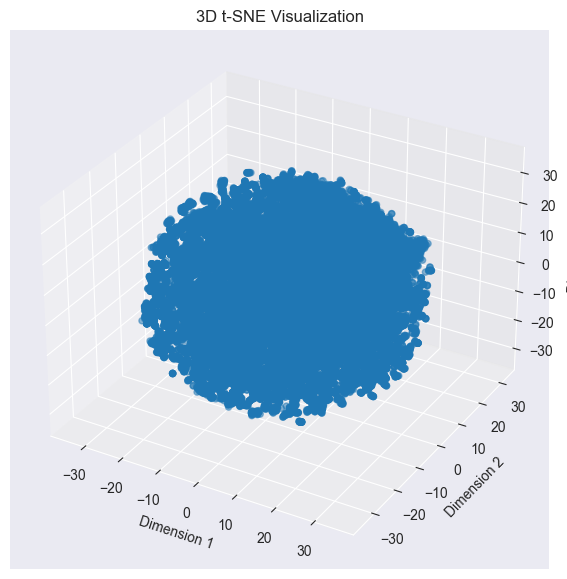

In [13]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Load your dataset
#data = np.load('path_to_your_dataset.npy')

# Flatten and standardize the data
#data_flattened = data.reshape(data.shape[0], -1)
#scaler = StandardScaler()
#data_standardized = scaler.fit_transform(data_flattened)

# Apply t-SNE with 3 components
tsne = TSNE(n_components=3, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(data_standardized)

# Plotting the result in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Scatter plot for 3D t-SNE results
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], alpha=0.5)

ax.set_title('3D t-SNE Visualization')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

plt.savefig('fig/scatterplot_first_3_tsne.eps')
plt.show()


In [14]:
import pandas as pd

X_std = StandardScaler().fit_transform(data_flattened)

# Convert the standardized data to a DataFrame
data_df = pd.DataFrame(X_std)

# Compute the correlation matrix
correlation_matrix = data_df.corr()

# The result is a DataFrame where each cell [i, j] represents the correlation between features i and j

threshold = 0.97  # Example threshold for strong correlations
strong_corrs = correlation_matrix.abs().stack().reset_index()
strong_corrs.columns = ['Feature_1', 'Feature_2', 'Correlation']
strong_corrs = strong_corrs[strong_corrs['Feature_1'] < strong_corrs['Feature_2']]  # Remove self-correlation and duplicates
strong_corrs = strong_corrs[strong_corrs['Correlation'] > threshold]

print(strong_corrs)
# Save the filtered strong correlations to a CSV file
strong_corrs.to_csv('strong_correlations.csv', index=False)


          Feature_1  Feature_2  Correlation
84886            11        186     1.000000
477463           62         63     0.970135
485164           63         64     0.971287
492865           64         65     0.972885
500566           65         66     0.971101
...             ...        ...          ...
58481395       7594       7595     0.970930
58489096       7595       7596     0.972015
58496797       7596       7597     0.972730
58504498       7597       7598     0.973503
58512199       7598       7599     0.974493

[1552 rows x 3 columns]


A heatmap is an effective way to visualize the correlation matrix, providing a color-coded representation of the correlation coefficients between pairs of features. Visualizing the entire 7,700 x 7,700 correlation matrix might not be practical due to its size, but you can visualize a subset or use techniques to make the full matrix more manageable.

Visualizing the Full Matrix (or a Large Subset)
Here's how to generate a heatmap for the correlation matrix or a significant subset thereof:



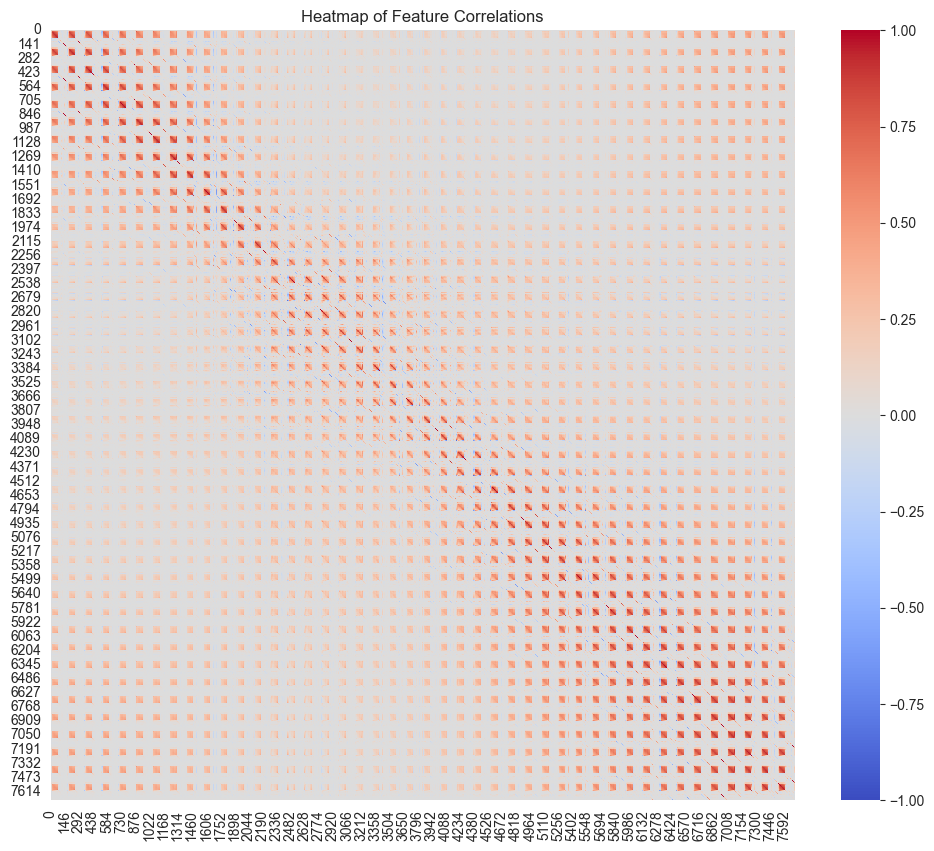

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# It might be practical to visualize a subset due to size
corr_subset = correlation_matrix.iloc[:7700, :7700]  # Adjust indices as needed

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations')
plt.savefig('fig/heatmap_all.eps')
plt.show()


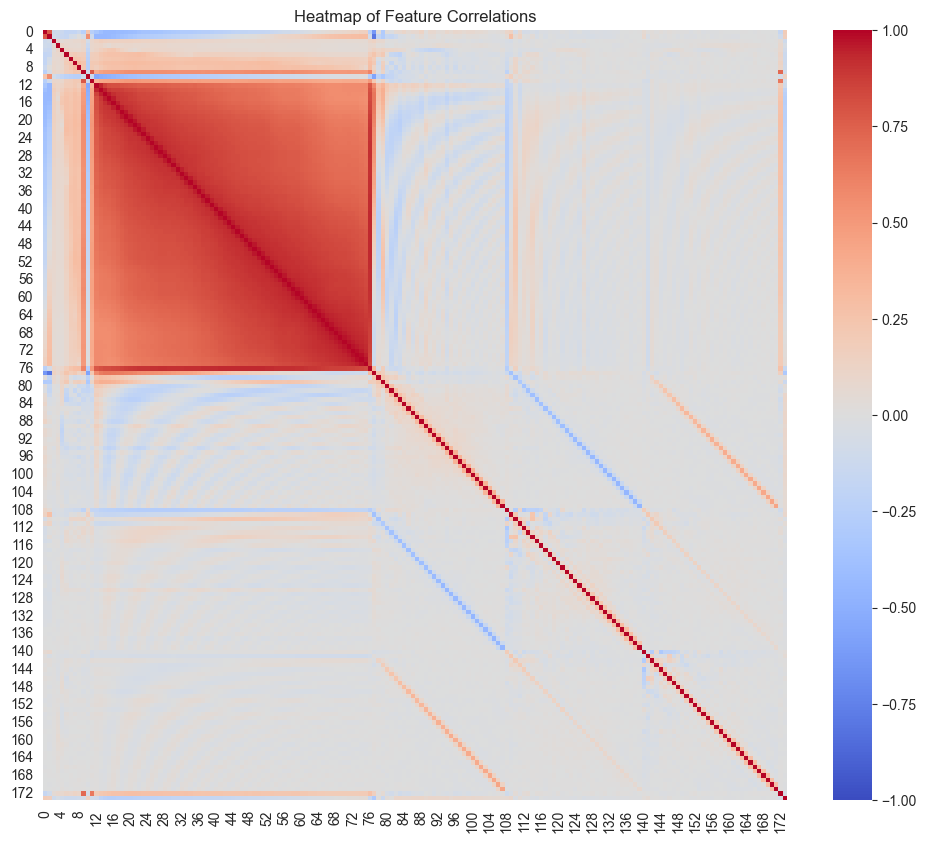

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# It might be practical to visualize a subset due to size.
corr_subset = correlation_matrix.iloc[:174, :174]  # Adjust indices as needed

plt.figure(figsize=(12, 10))
sns.heatmap(corr_subset, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Heatmap of Feature Correlations')
plt.savefig('fig/heatmap_single.eps')
plt.show()

Visualizing Strong Correlations Only
If specifically interested in strong correlations, we might visualize only those entries from the strong_corrs DataFrame. This approach requires a bit more preprocessing to create a matrix form suitable for a heatmap:

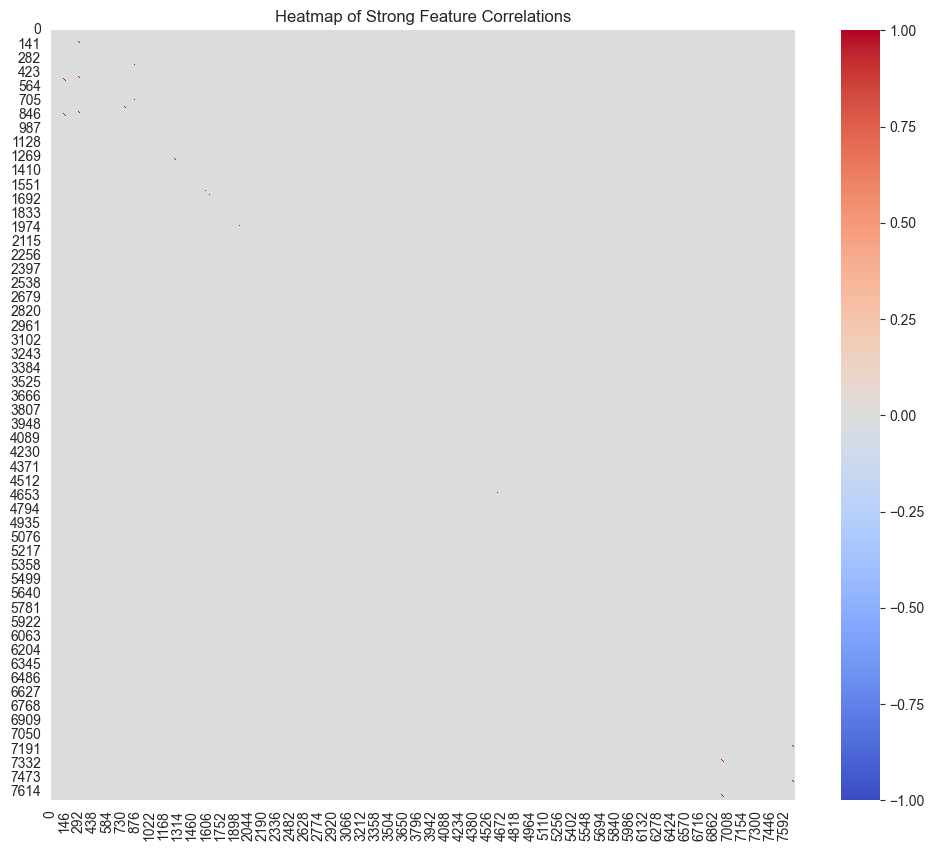

In [18]:
# Assuming strong_corrs is already filtered for strong correlations
# Create an empty matrix to fill with strong correlations
strong_corr_matrix = pd.DataFrame(0, index=np.arange(len(correlation_matrix)), columns=correlation_matrix.columns)

# Fill the matrix with the strong correlation values
for index, row in strong_corrs.iterrows():
    feature_1, feature_2, corr_value = row['Feature_1'], row['Feature_2'], row['Correlation']
    strong_corr_matrix.at[feature_1, feature_2] = corr_value
    strong_corr_matrix.at[feature_2, feature_1] = corr_value  # Symmetric

# Now visualize this matrix
plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr_matrix, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Heatmap of Strong Feature Correlations')
plt.show()



##### Scatter Plots
Scatter plots can help visualize outliers in the context of two features. Outliers may appear far from the main cluster of data points.


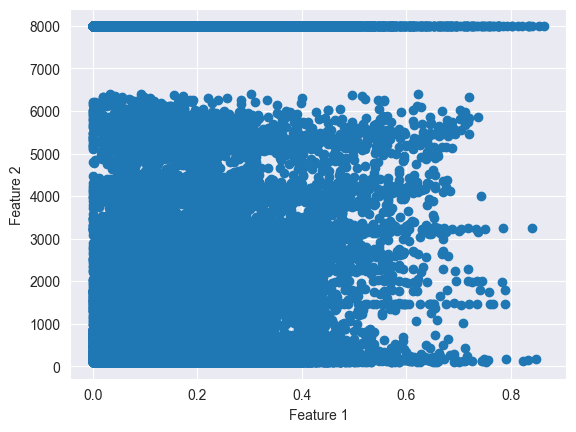

In [17]:
plt.scatter(features[:,174,0], features[:,173,0])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.savefig('fig/scatterplot_173_174.eps')
plt.show()


#### **Domain-Specific Criteria**

In some cases, knowledge about the specific domain can help identify outliers. For example, if we know the expected range of feature values for audio energy, we can flag data points that fall outside this range as outliers. Unfortunately, we don't.

### Handling Outliers

Once identified, there are several options for dealing with outliers:
- **Remove**: If we're confident an outlier is due to error or noise, removing it might be best.
- **Cap/Floor**: Replace outlier values with the maximum/minimum allowed value.
- **Adjust**: For slightly off values, you might adjust them based on domain knowledge or surrounding data points.
- **Keep**: Sometimes, what appears to be an outlier is a valid data point that should be included in the analysis.



### 5. Checking Label Consistency

If metadata includes labels, ensure they're consistent (e.g., all labels are correctly spelled and used uniformly). If labels are stored separately, you'd load them similarly and inspect their distribution and consistency.


Given the structure of the `development.csv` file, where each row contains an ID that corresponds to the sample index in the feature data, along with other information like `filename`, `speaker_id`, and the spoken `word`, we can use the `speaker_id` or `word` as categorical labels for clustering validation. Here's how to integrate these labels with clustering results for analysis and visualization:

### 1. Load the Labels
First, load the labels from the CSV file and align them with feature data by the sample index.


In [18]:
import pandas as pd

# Load the labels
labels_df = pd.read_csv('../dataset/development.csv')

# Assuming you're interested in 'speaker_id' or 'word' as labels
category_labels = labels_df['word']  # or labels_df['speaker_id']


### 2. Perform Clustering
Use the feature data to perform clustering, as previously discussed. For illustration, let's use K-Means clustering:


In [19]:
from sklearn.cluster import KMeans

# Assuming X_std is your standardized feature data
kmeans = KMeans(n_clusters=21, random_state=0).fit(X_std)  # Adjust n_clusters based on your category_labels
cluster_labels = kmeans.labels_

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



### 3. Analyze and Visualize Clustering vs. Categories
Now that we have both clustering results (`cluster_labels`) and true categories (`category_labels`), we can compare them to assess how well the clustering reflects the actual categories. This can be done through various methods, including visualization and metrics like the Adjusted Rand Index (ARI).

#### Visualizing with t-SNE:

Perform a t-SNE reduction for visualization purposes and plot the results, coloring by both the clustering labels and the true categories:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


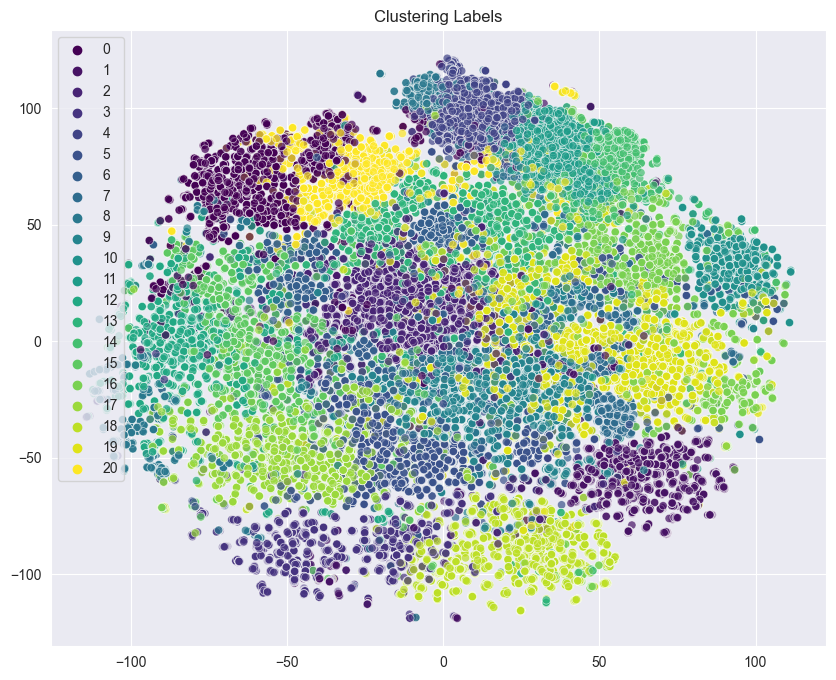

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


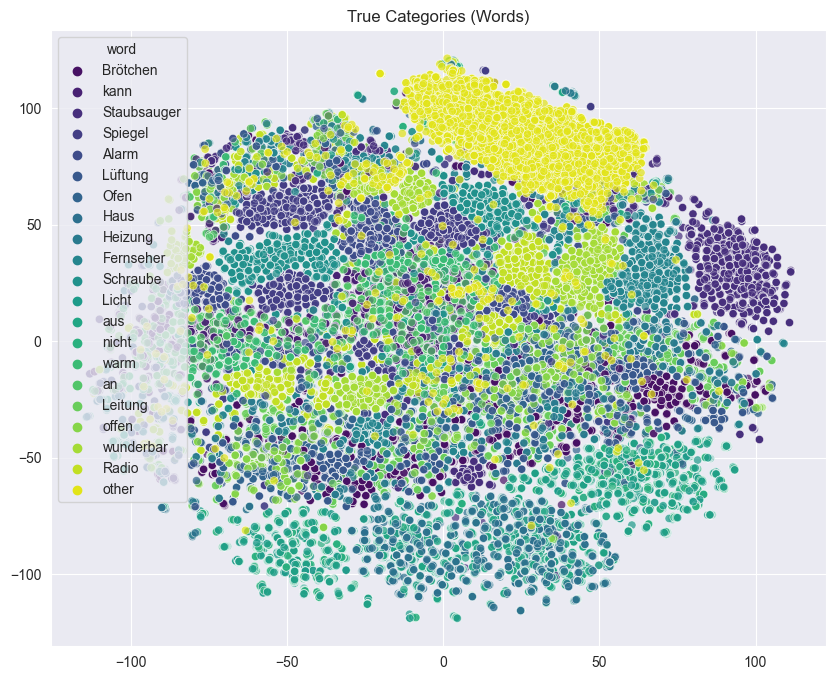

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Apply t-SNE to reduce dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_std)

# Plotting with clustering labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette='viridis', alpha=0.7, legend="full")
plt.title('Clustering Labels')
plt.savefig('fig/scatterplot_cluster_natural_tsne.eps')
plt.show()

# Plotting with true categories (speaker_id)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=category_labels, palette='viridis', alpha=0.7, legend="full")
plt.title('True Categories (Words)')
plt.savefig('fig/scatterplot_cluster_categories_tsne.eps')
plt.show()


#### Confusion Matrix and ARI:

A confusion matrix or an ARI score can provide quantitative measures of the agreement between clustering results and the true categories.


In [21]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert both sets of labels to strings to ensure uniformity
category_labels_str = np.array(category_labels).astype(str)
cluster_labels_str = np.array(cluster_labels).astype(str)

# Combine all labels to ensure the encoder knows about all of them
all_labels_str = np.concatenate((category_labels_str, cluster_labels_str))
label_encoder = LabelEncoder()

# Fit the encoder on all possible labels (now uniformly strings)
label_encoder.fit(all_labels_str)

# Now encode both sets of labels
category_labels_encoded = label_encoder.transform(category_labels_str)
cluster_labels_encoded = label_encoder.transform(cluster_labels_str)

# Compute the confusion matrix and ARI score
conf_matrix = confusion_matrix(category_labels_encoded, cluster_labels_encoded)
print(conf_matrix)

ari_score = adjusted_rand_score(category_labels_encoded, cluster_labels_encoded)
print(f"ARI Score: {ari_score}")


[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [132  21   3 ...   0   0   0]
 [ 75   2   0 ...   0   0   0]
 [114   4   2 ...   0   0   0]]
ARI Score: 0.17482900751650168


In the above, 1 means "perfect match", 0 means "pure random". Not too good, thus. Let's try DBSCAN instead of K-means:

k-nearest to help select a reasonable `eps` value for DBSCAN:

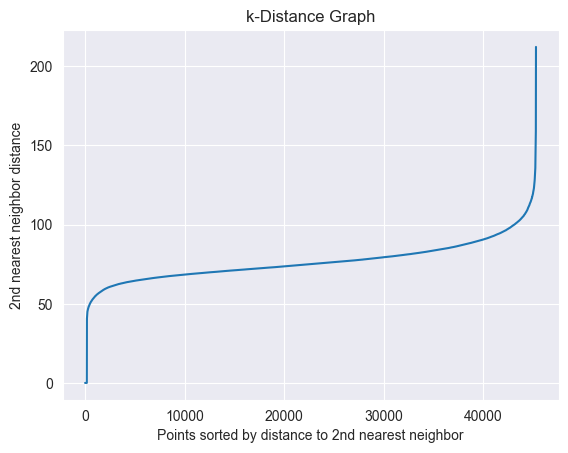

In [22]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_std)
distances, indices = neighbors_fit.kneighbors(X_std)

# Sort distance values by ascending value
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.plot(distances)
plt.title('k-Distance Graph')
plt.xlabel('Points sorted by distance to 2nd nearest neighbor')
plt.ylabel('2nd nearest neighbor distance')
plt.show()


Ähem - what will that tell us???

In [23]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

# Choose the number of components such that a high percentage of variance is retained, say 95%
pca = PCA(n_components=0.8)
X_pca = pca.fit_transform(X_std)

# Now X_pca contains the reduced data. Let's see how many components PCA has chosen.
print(f"PCA reduced the data to {X_pca.shape[1]} dimensions")

# After this, you can apply DBSCAN to the reduced data.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)  # Example parameters; adjust based on your data
dbscan_labels = dbscan.fit_predict(X_pca)

# Calculate the ARI score with respect to the true labels
ari_score_dbscan = adjusted_rand_score(category_labels, dbscan_labels)
print(f"ARI score with DBSCAN: {ari_score_dbscan}")


PCA reduced the data to 347 dimensions
ARI score with DBSCAN: -8.008953846866439e-05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


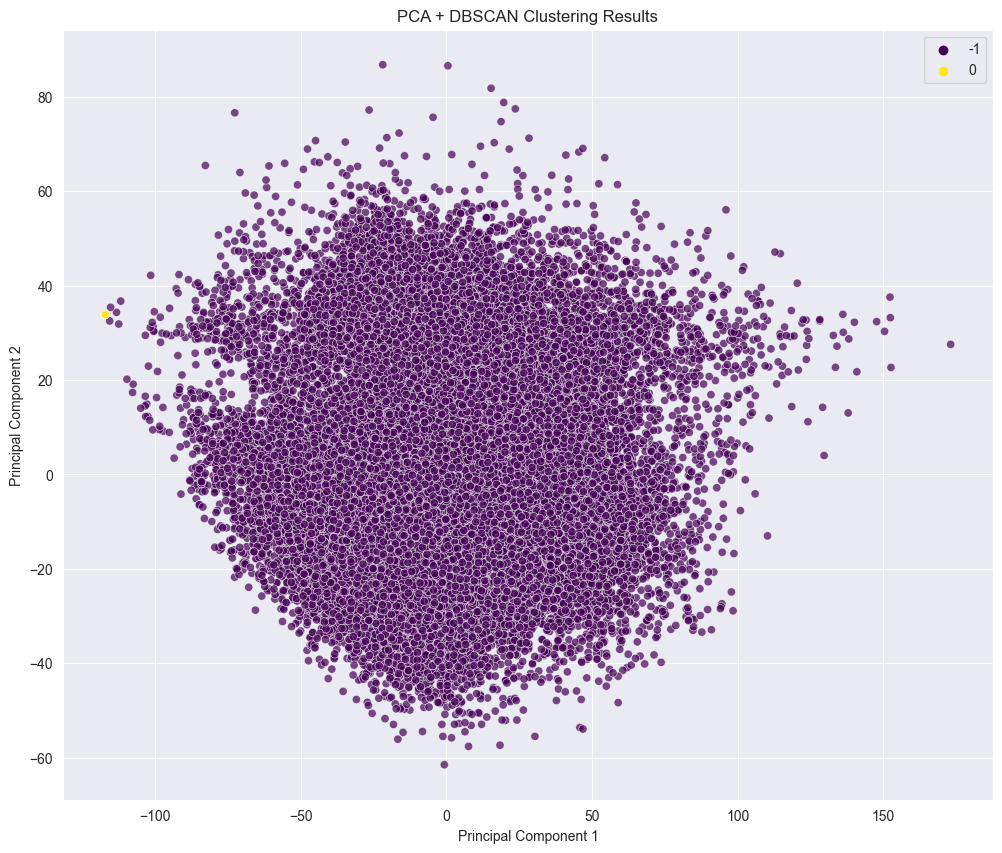

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you've reduced your data to two dimensions with PCA
# and have clustered this reduced data to get `dbscan_labels`

# Create a scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='viridis', alpha=0.7, legend="full")
plt.title('PCA + DBSCAN Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.savefig('fig/scatterplot_first_2_dbscan_pca.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


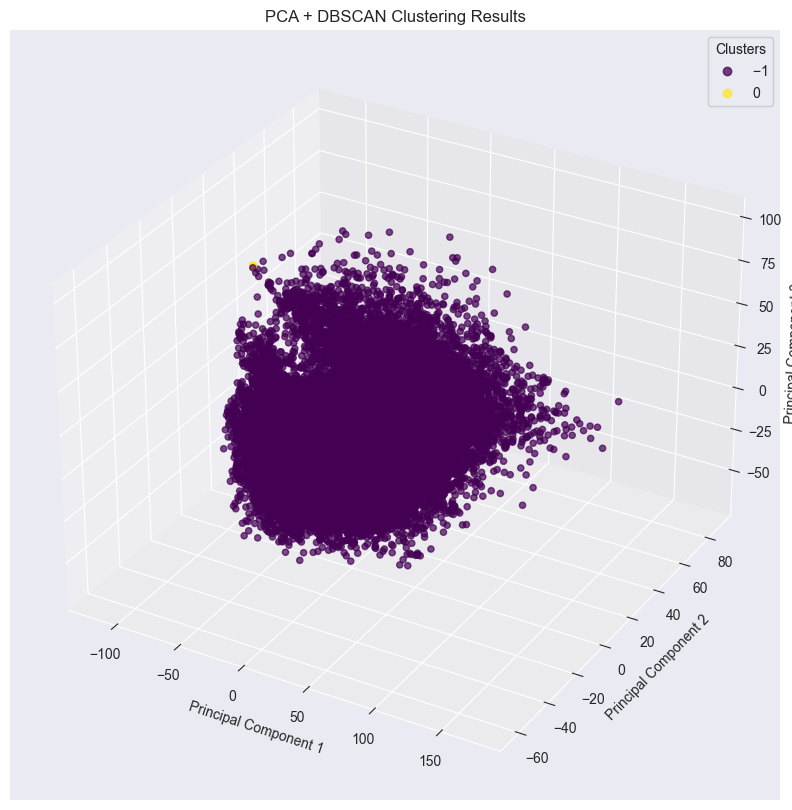

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=dbscan_labels, cmap='viridis', alpha=0.7)

# Add labels and title
ax.set_title('PCA + DBSCAN Clustering Results')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.savefig('fig/scatterplot_first_3_dbscan_pca.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


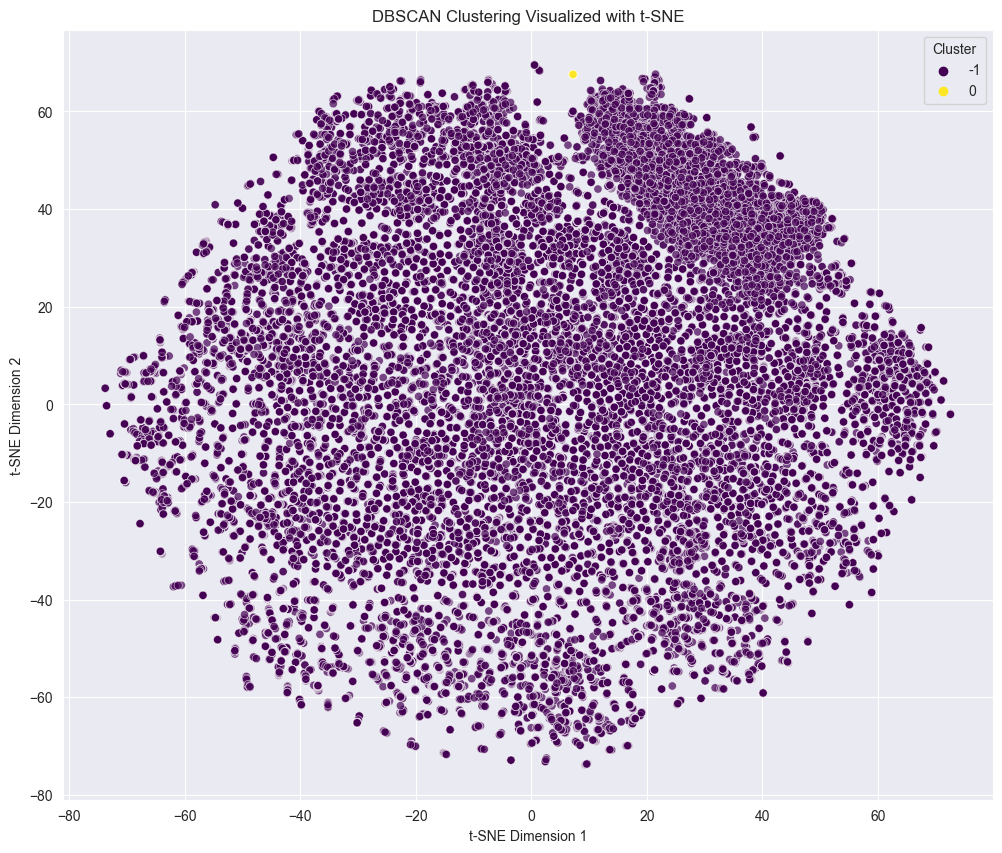

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dbscan_labels` are the labels obtained from DBSCAN
# and `X_std` is your standardized feature data

# Apply t-SNE to reduce the data to two dimensions for visualization
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)
X_tsne = tsne.fit_transform(X_std)

# Plotting
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=dbscan_labels, palette="viridis", alpha=0.7, legend="full")
plt.title('DBSCAN Clustering Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')

plt.savefig('fig/scatterplot_first_2_dbscan_tsne.eps')
plt.show()



### Conclusion
This process allows you to validate the efficacy of your clustering against predefined categories, providing insight into the natural grouping of your data as per the clustering algorithm and how it compares with known categories. This comparison can highlight the strengths and limitations of the clustering approach in capturing the underlying structure of your dataset.

#### b. Auditory Examination
- **Method**: Listen to a random subset of recordings across different labels to assess biases.
- **Tip**: Report on accent, age, or background noise biases. Consider if the dataset includes a diverse representation of users and environments.

* Sample Recordings: Listen to a small, random set of recordings from each label to get a sense of the data's variety. Pay attention to accents, speech speed, and background noise.
* Biases: Note any biases you observe. For example, if all recordings are from speakers with the same accent or if background noise is consistently present, it might limit the model's ability to generalize to other environments.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


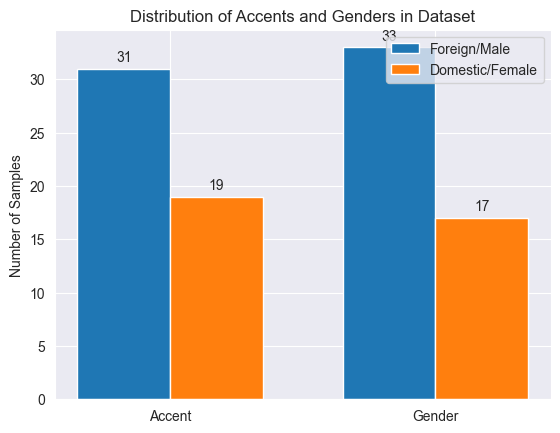

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define the categories and data
categories = ['Accent', 'Gender']
foreign = 31
domestic = 19
male = 33
female = 17

# Creating bar positions
ind = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(ind - width/2, [foreign, male], width, label='Foreign/Male')
bar2 = ax.bar(ind + width/2, [domestic, female], width, label='Domestic/Female')

# Adding labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Samples')
ax.set_title('Distribution of Accents and Genders in Dataset')
ax.set_xticks(ind)
ax.set_xticklabels(categories)
ax.legend()

# Function to add a label on top of each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

plt.savefig('fig/biases.eps')
plt.show()


* Representativeness: Consider whether the samples seem representative of real-world usage. Are there any speech patterns, background noises, or situations missing that you'd expect in a household setting?

#### c. "Other" Sounds Classification
- **Method**: Categorize the types of "Other" sounds identified upon listening.
- **Tip**: Discuss whether these sounds are common in household settings and could interfere with command recognition.

* Explore "Other" Sounds: Listen to several examples from the "Other" category to identify the types of sounds included. Are these sounds likely to be encountered in a household environment (e.g., door closing, appliances working, pets)?
* Representativeness of "Other" Sounds: Determine whether the "Other" category is comprehensive enough to include a wide variety of household sounds. This is important for ensuring the model can distinguish between command words and background noise.


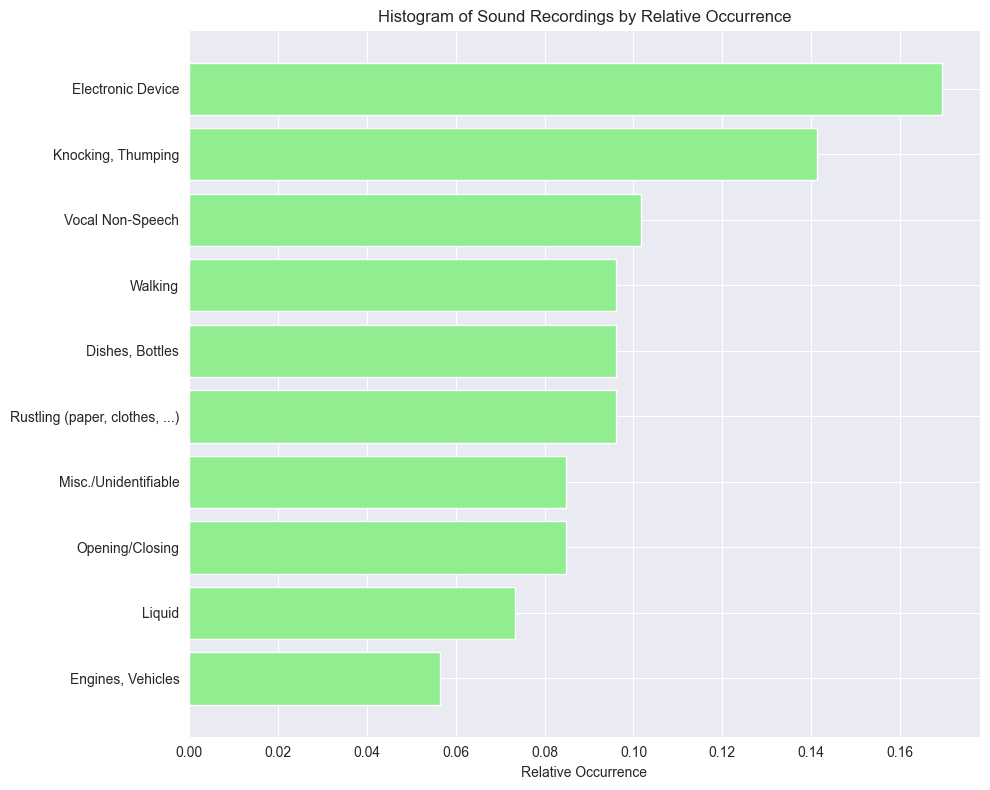

In [6]:
import matplotlib.pyplot as plt

# Data for sound recordings
sounds = {
    "Knocking, Thumping": 25,
    "Liquid": 13,
    "Electronic Device": 30,
    "Rustling (paper, clothes, ...)": 17,
    "Opening/Closing": 15,
    "Dishes, Bottles": 17,
    "Vocal Non-Speech": 18,
    "Misc./Unidentifiable": 15,
    "Walking": 17,
    "Engines, Vehicles": 10
}

# Sorting the sounds by their occurrences
sounds_sorted = dict(sorted(sounds.items(), key=lambda item: item[1]))

# Calculating total number of occurrences for normalization
total_occurrences = sum(sounds_sorted.values())

# Calculating relative occurrences
relative_occurrences = {sound: count / total_occurrences for sound, count in sounds_sorted.items()}

# Creating the histogram for relative occurrences
plt.figure(figsize=(10, 8))
plt.barh(list(relative_occurrences.keys()), list(relative_occurrences.values()), color='lightgreen')
plt.xlabel('Relative Occurrence')
plt.title('Histogram of Sound Recordings by Relative Occurrence')
plt.tight_layout()

plt.savefig('fig/other.eps')
plt.show()


In [10]:
import matplotlib.pyplot as plt

# Data for sound recordings
sounds = {
    "Knocking, Thumping": 25,
    "Liquid": 13,
    "Electronic Device": 30,
    "Rustling (paper, clothes, ...)": 17,
    "Opening/Closing": 15,
    "Dishes, Bottles": 17,
    "Vocal Non-Speech": 18,
    "Misc./Unidentifiable": 15,
    "Walking": 17,
    "Engines, Vehicles": 10
}

# Sorting the sounds by their occurrences
sounds_sorted = dict(sorted(sounds.items(), key=lambda item: item[1], reverse=True))

# Calculating total number of occurrences for normalization
total_occurrences = sum(sounds_sorted.values())

# Calculating relative occurrences
relative_occurrences = {sound: (count / total_occurrences) * 100 for sound, count in sounds_sorted.items()}

# Generate LaTeX table code
latex_table = "\\begin{table}[h]\n\\centering\n\\caption{Distribution of 'Other' Sounds}\n\\label{tab:sounds_distribution}\n"
latex_table += "\\begin{tabular}{lr}\n\\toprule\nSound Category & Relative Occurrence (\\%) \\\\\n\\midrule\n"
for sound, occurrence in relative_occurrences.items():
    latex_table += f"{sound} & {occurrence:.2f}\\% \\\\\n"
latex_table += "\\bottomrule\n\\end{tabular}\n\\end{table}"

# Print LaTeX table code
print(latex_table)
}

\begin{table}[h]
\centering
\caption{Distribution of 'Other' Sounds}
\label{tab:sounds_distribution}
\begin{tabular}{lr}
\toprule
Sound Category & Relative Occurrence (\%) \\
\midrule
Electronic Device & 16.95\% \\
Knocking, Thumping & 14.12\% \\
Vocal Non-Speech & 10.17\% \\
Rustling (paper, clothes, ...) & 9.60\% \\
Dishes, Bottles & 9.60\% \\
Walking & 9.60\% \\
Opening/Closing & 8.47\% \\
Misc./Unidentifiable & 8.47\% \\
Liquid & 7.34\% \\
Engines, Vehicles & 5.65\% \\
\bottomrule
\end{tabular}
\end{table}


### 2. Label Characteristics

#### a. Grouping Strategy
- **Method**: Propose a logical grouping of the 20 words based on their functional use or similarity in sound.
- **Tip**: Explain rationale, focusing on the goal to enhance recognition accuracy or to mitigate confusion between similar commands.

#### b. Class Balance Evaluation
- **Method**: Calculate the distribution of labels to identify any imbalances.
- **Tip**: Discuss potential challenges with unbalanced data, such as model bias towards more frequent labels, and propose strategies to address this (e.g., data augmentation, resampling).

### 3. Feature Characteristics

#### a. Distribution Analysis
- **Method**: Visualize the distributions of pre-computed features using histograms or density plots.
- **Tip**: Identify features with skewed or multimodal distributions that might need normalization or transformation.

#### b. Correlation Analysis
- **Method**: Utilize correlation matrices or scatter plots to identify correlated features.
- **Tip**: Suggest if and how you might reduce dimensionality or remove redundant features to improve model efficiency.

#### c. Speaker Variation
- **Method**: Analyze feature distributions across different speakers.
- **Tip**: Discuss if there are noticeable differences that could impact model performance and how speaker normalization could be applied.

### 4. Feature / Label Agreement

#### a. Feature Usefulness
- **Method**: Apply techniques like feature importance from tree-based models or univariate feature selection.
- **Tip**: Highlight features with strong correlations to labels and discuss their relevance for classification.

#### b. Similar Words Feature Distribution
- **Method**: Compare the feature distributions of similar-sounding words.
- **Tip**: Explore if these distributions overlap significantly and discuss implications for distinguishing these commands in practice.

### 5. Conclusion

- **Synthesis**: Bring together key findings, emphasizing insights on data quality, label and feature characteristics, and their implications for model development.
- **Recommendations**: Offer concrete suggestions based on the above analysis for improving the dataset or model training approach.

### Contribution Statement

- Detail each team member's contributions succinctly, ensuring transparency and accountability in your collaborative effort.

The report should not only answer these questions but also be concise, given the page limit. Use visual aids (charts, graphs) effectively to complement textual analysis, keeping the balance between text and visuals within the prescribed limit.